# Olist E-Commerce Data Exploration and Visualization

In this notebook, we'll explore the Olist E-commerce dataset and connect directly to a PostgreSQL database that houses our facts and dimensions. We will:
- Establish a database connection using a configuration file.
- Retrieve and visualize trends in orders, revenue, and customer behavior.
- Examine product category performance to identify top-performing categories.
- Perform geographic analysis to understand regional performance in terms of revenue, average order values, and customers.
- Segment customers by their spending to better understand buyer behavior.

Let's start by setting up our environment and verifying our database connection.

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import psycopg2
from configparser import ConfigParser

# Function to read database configuration
def get_db_config(filename='../config/database.ini', section='postgresql'):
    """Read database configuration from an .ini file."""
    parser = ConfigParser()
    parser.read(filename)
    if parser.has_section(section):
        params = {param[0]: param[1] for param in parser.items(section)}
        return params
    else:
        raise Exception(f"Section {section} not found in {filename}")

# Function to create a database connection
def create_connection():
    """Create a database connection using the retrieved configuration."""
    try:
        params = get_db_config()
        connection = psycopg2.connect(**params)
        return connection
    except Exception as e:
        print(f"Error connecting to database: {str(e)}")
        return None

# Test the connection
conn = create_connection()
if conn is not None:
    print("Database connection successful!")
    # Simple test query
    test_query = "SELECT COUNT(*) FROM fact_orders"
    test_df = pd.read_sql_query(test_query, conn)
    print(f"Total orders in database: {test_df.iloc[0,0]}")
else:
    print("Failed to connect to the database. Please check your configuration.")

Database connection successful!
Total orders in database: 450600


C:\Users\hp\AppData\Local\Temp\ipykernel_24976\954700701.py:35: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  test_df = pd.read_sql_query(test_query, conn)


With a successful connection, we can now proceed to our analyses. Let's also configure our plotting environment to maintain a consistent visualization style throughout the notebook.

In [34]:
# Visualization preferences
sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14

# Helper function to execute queries
def get_data(query):
    """Execute SQL query and return a DataFrame."""
    try:
        return pd.read_sql_query(query, conn)
    except Exception as e:
        print(f"Error executing query: {str(e)}")
        return None

## 1. Sales Trends Over Time

We will examine how the key metrics — total orders, total sales, average order value, and unique customers — evolve over time. This provides insights into the seasonality, growth, and overall health of the business.

C:\Users\hp\AppData\Local\Temp\ipykernel_24976\1508245647.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query(query, conn)


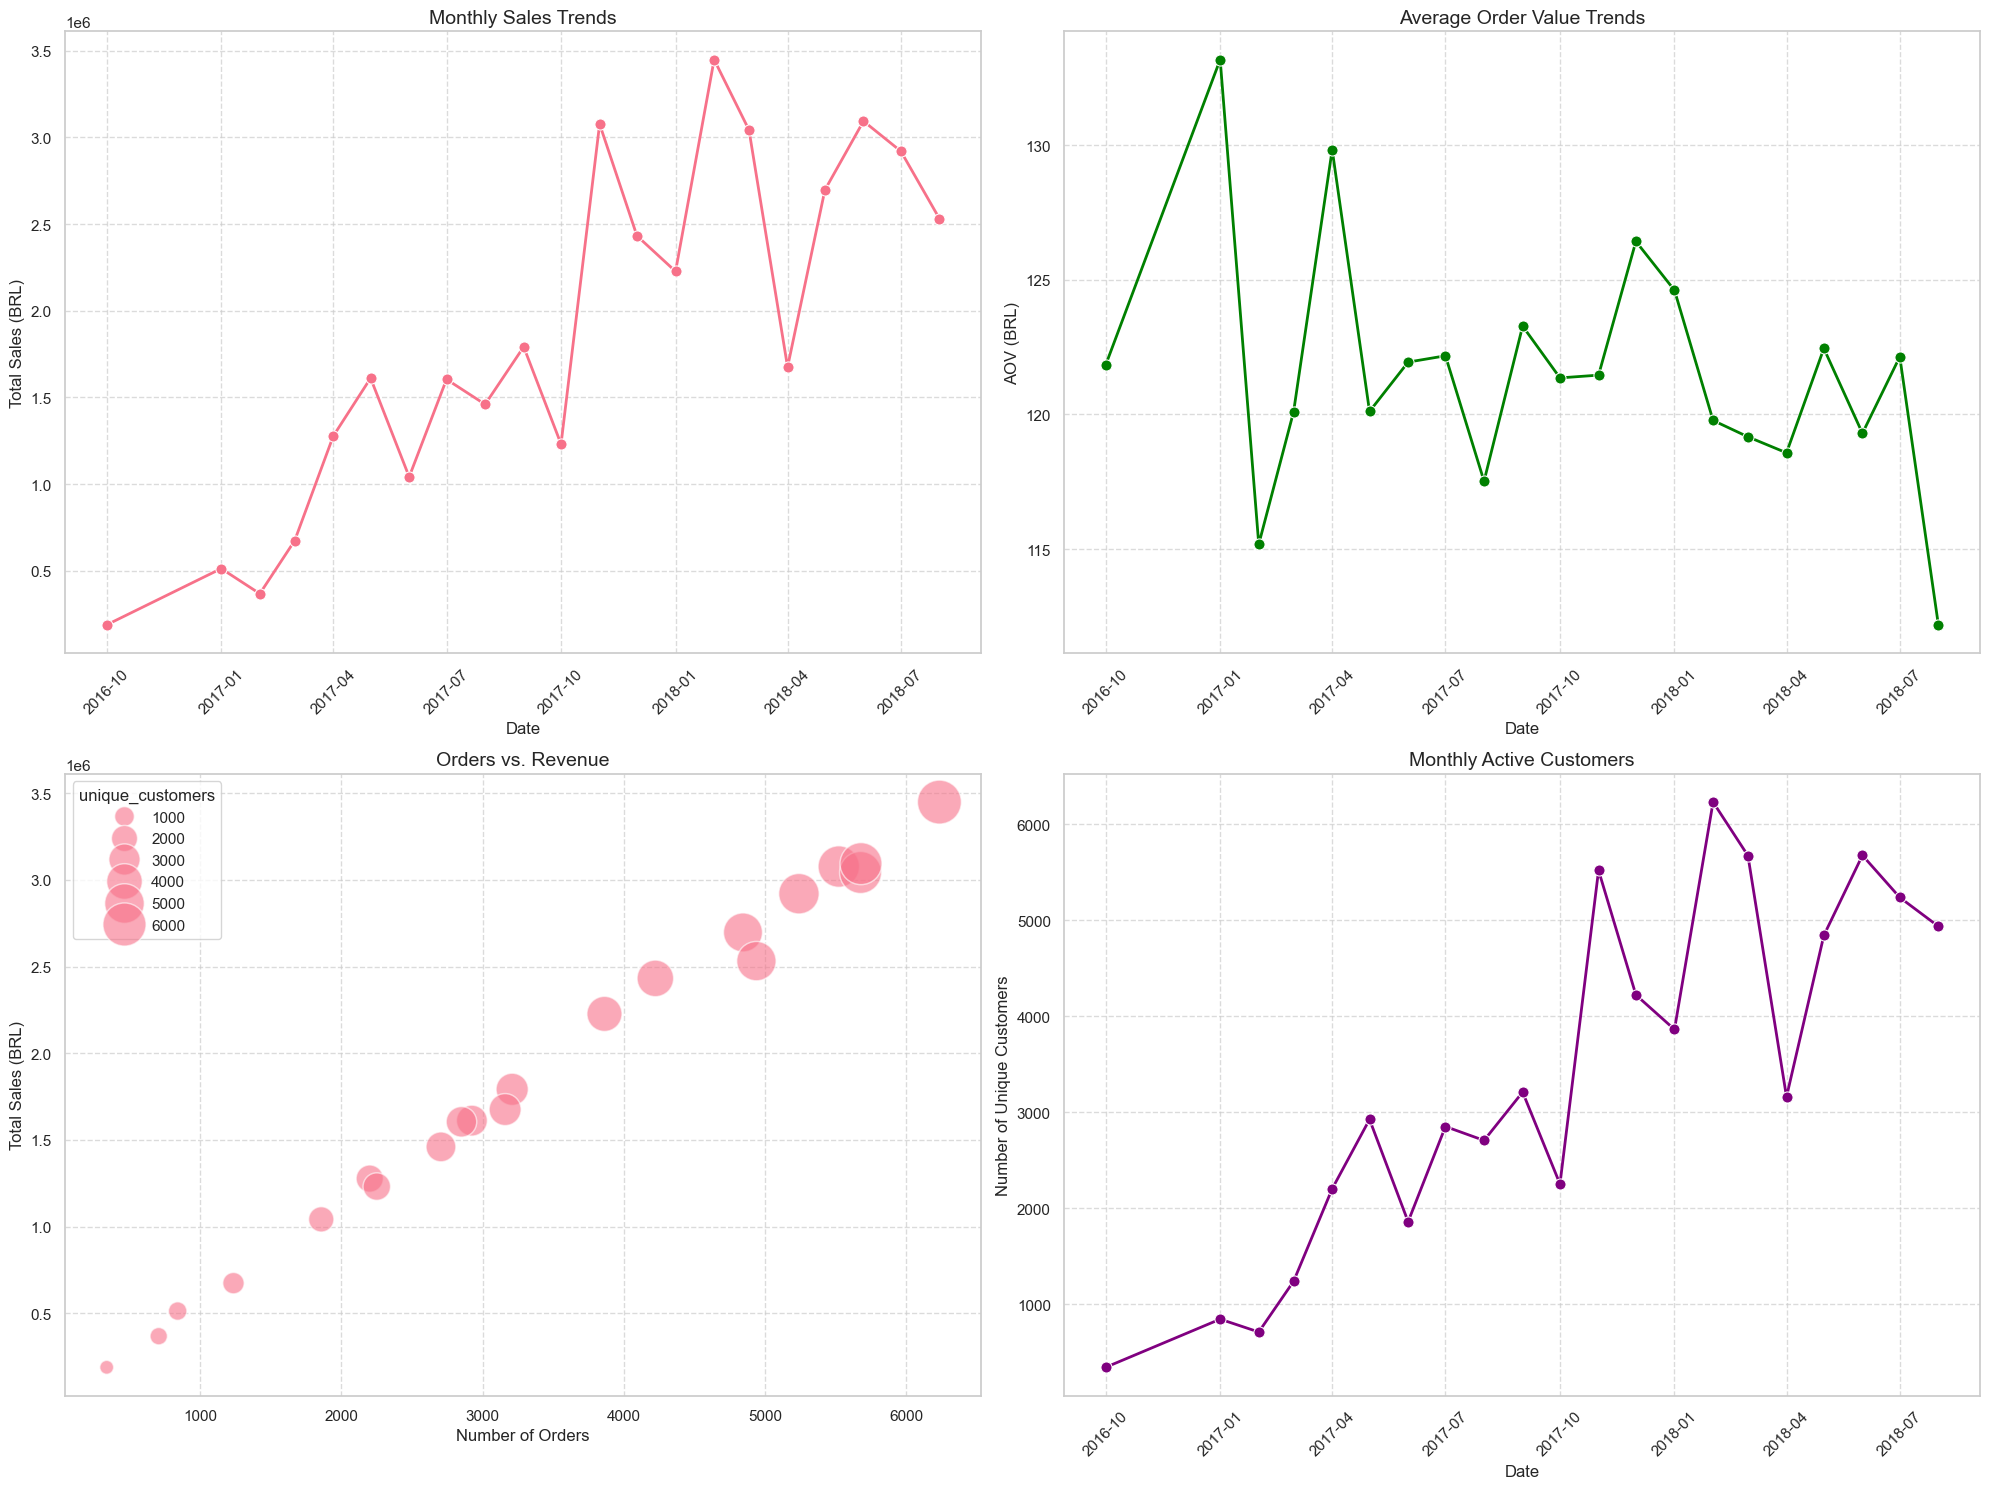

In [35]:
query_sales_trends = """
SELECT 
    d.year,
    d.month,
    COUNT(DISTINCT f.order_id) as total_orders,
    SUM(f.price) as total_sales,
    AVG(f.price) as avg_order_value,
    COUNT(DISTINCT f.customer_key) as unique_customers
FROM fact_orders f
JOIN dim_date d ON f.purchase_date_key = d.date_key
GROUP BY d.year, d.month
ORDER BY d.year, d.month;
"""

sales_trends = get_data(query_sales_trends)

# Create a proper datetime column for plotting
sales_trends['date'] = pd.to_datetime(sales_trends[['year', 'month']].assign(day=1))

# Visualize monthly metrics
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))

# (1) Monthly Total Sales
sns.lineplot(data=sales_trends, x='date', y='total_sales', ax=ax1, marker='o', linewidth=2, markersize=8)
ax1.set_title('Monthly Sales Trends')
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Sales (BRL)')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, linestyle='--', alpha=0.7)

# (2) Average Order Value Over Time
sns.lineplot(data=sales_trends, x='date', y='avg_order_value', ax=ax2, marker='o', color='green', linewidth=2, markersize=8)
ax2.set_title('Average Order Value Trends')
ax2.set_xlabel('Date')
ax2.set_ylabel('AOV (BRL)')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, linestyle='--', alpha=0.7)

# (3) Relationship Between Orders and Revenue
sns.scatterplot(data=sales_trends, x='total_orders', y='total_sales', ax=ax3, size='unique_customers', sizes=(100, 1000), alpha=0.6)
ax3.set_title('Orders vs. Revenue')
ax3.set_xlabel('Number of Orders')
ax3.set_ylabel('Total Sales (BRL)')
ax3.grid(True, linestyle='--', alpha=0.7)

# (4) Customer Growth Over Time
sns.lineplot(data=sales_trends, x='date', y='unique_customers', ax=ax4, marker='o', color='purple', linewidth=2, markersize=8)
ax4.set_title('Monthly Active Customers')
ax4.set_xlabel('Date')
ax4.set_ylabel('Number of Unique Customers')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## 2. Product Category Performance

Next, let's look into product-level performance. We will focus on categories with at least 100 orders and visualize the top 10 categories by total revenue. This helps us understand which product segments are driving the most value.

C:\Users\hp\AppData\Local\Temp\ipykernel_24976\1508245647.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query(query, conn)


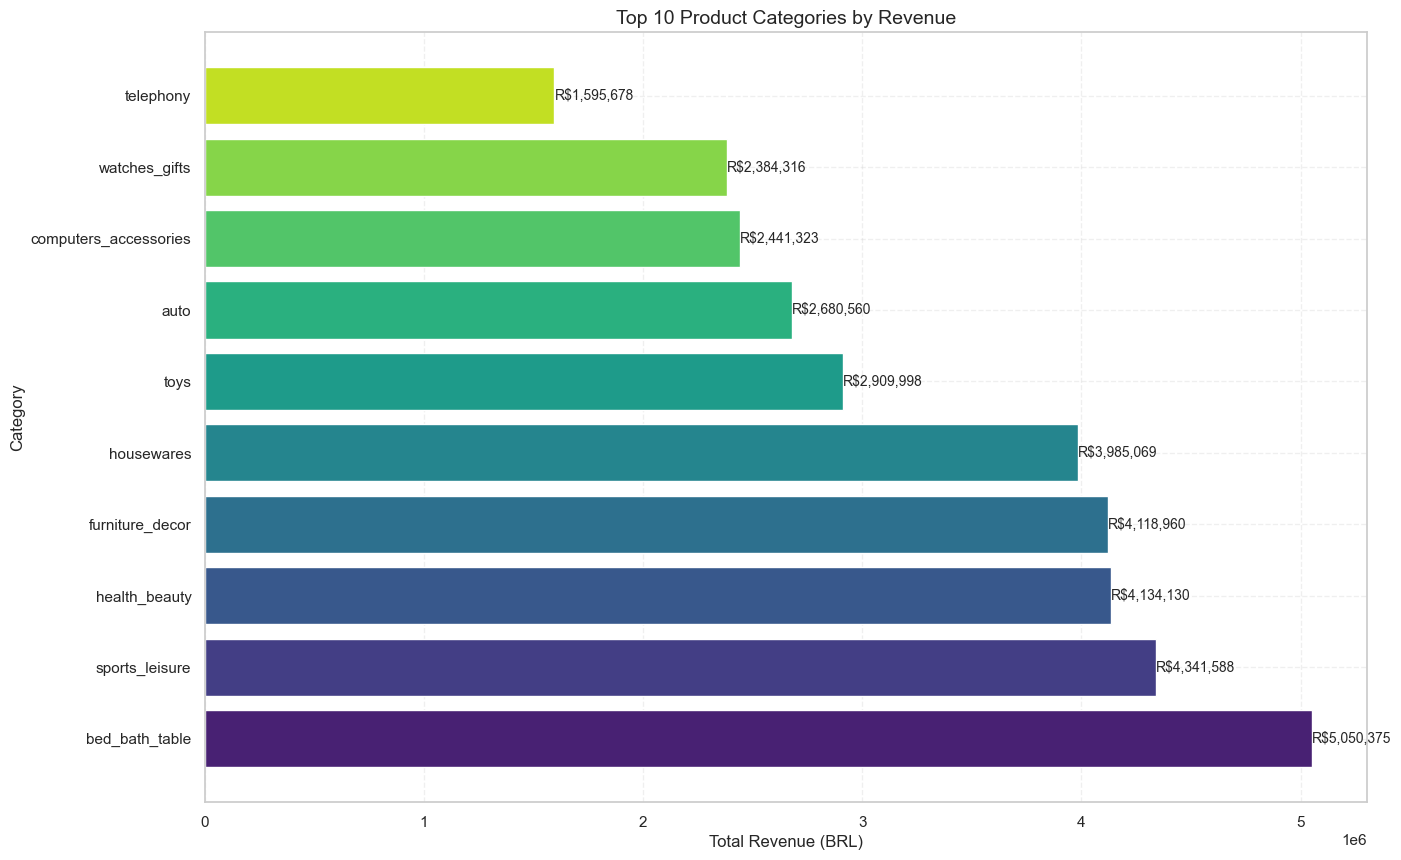

In [36]:
query_product_analysis = """
SELECT 
    p.product_category_name_english,
    COUNT(DISTINCT f.order_id) as order_count,
    SUM(f.price) as total_revenue,
    AVG(f.price) as avg_price,
    COUNT(DISTINCT f.customer_key) as unique_customers,
    SUM(f.price) / COUNT(DISTINCT f.customer_key) as revenue_per_customer
FROM fact_orders f
JOIN dim_product p ON f.product_key = p.product_key
GROUP BY p.product_category_name_english
HAVING COUNT(DISTINCT f.order_id) > 100
ORDER BY total_revenue DESC;
"""

product_analysis = get_data(query_product_analysis)

# Top 10 categories by revenue
top_10_categories = product_analysis.head(10)

plt.figure(figsize=(15, 10))
colors = sns.color_palette("viridis", n_colors=len(top_10_categories))
bars = plt.barh(top_10_categories['product_category_name_english'], top_10_categories['total_revenue'], color=colors)

# Add value labels for each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f'R${width:,.0f}', va='center', fontsize=10)

plt.title('Top 10 Product Categories by Revenue')
plt.xlabel('Total Revenue (BRL)')
plt.ylabel('Category')
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

## 3. Geographic Analysis

Understanding geographical distribution of sales can guide marketing and logistics decisions. We will:
- Compare total revenue and unique customers by state.
- Examine average order values and revenue per customer to identify high-value regions.

C:\Users\hp\AppData\Local\Temp\ipykernel_24976\1508245647.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query(query, conn)


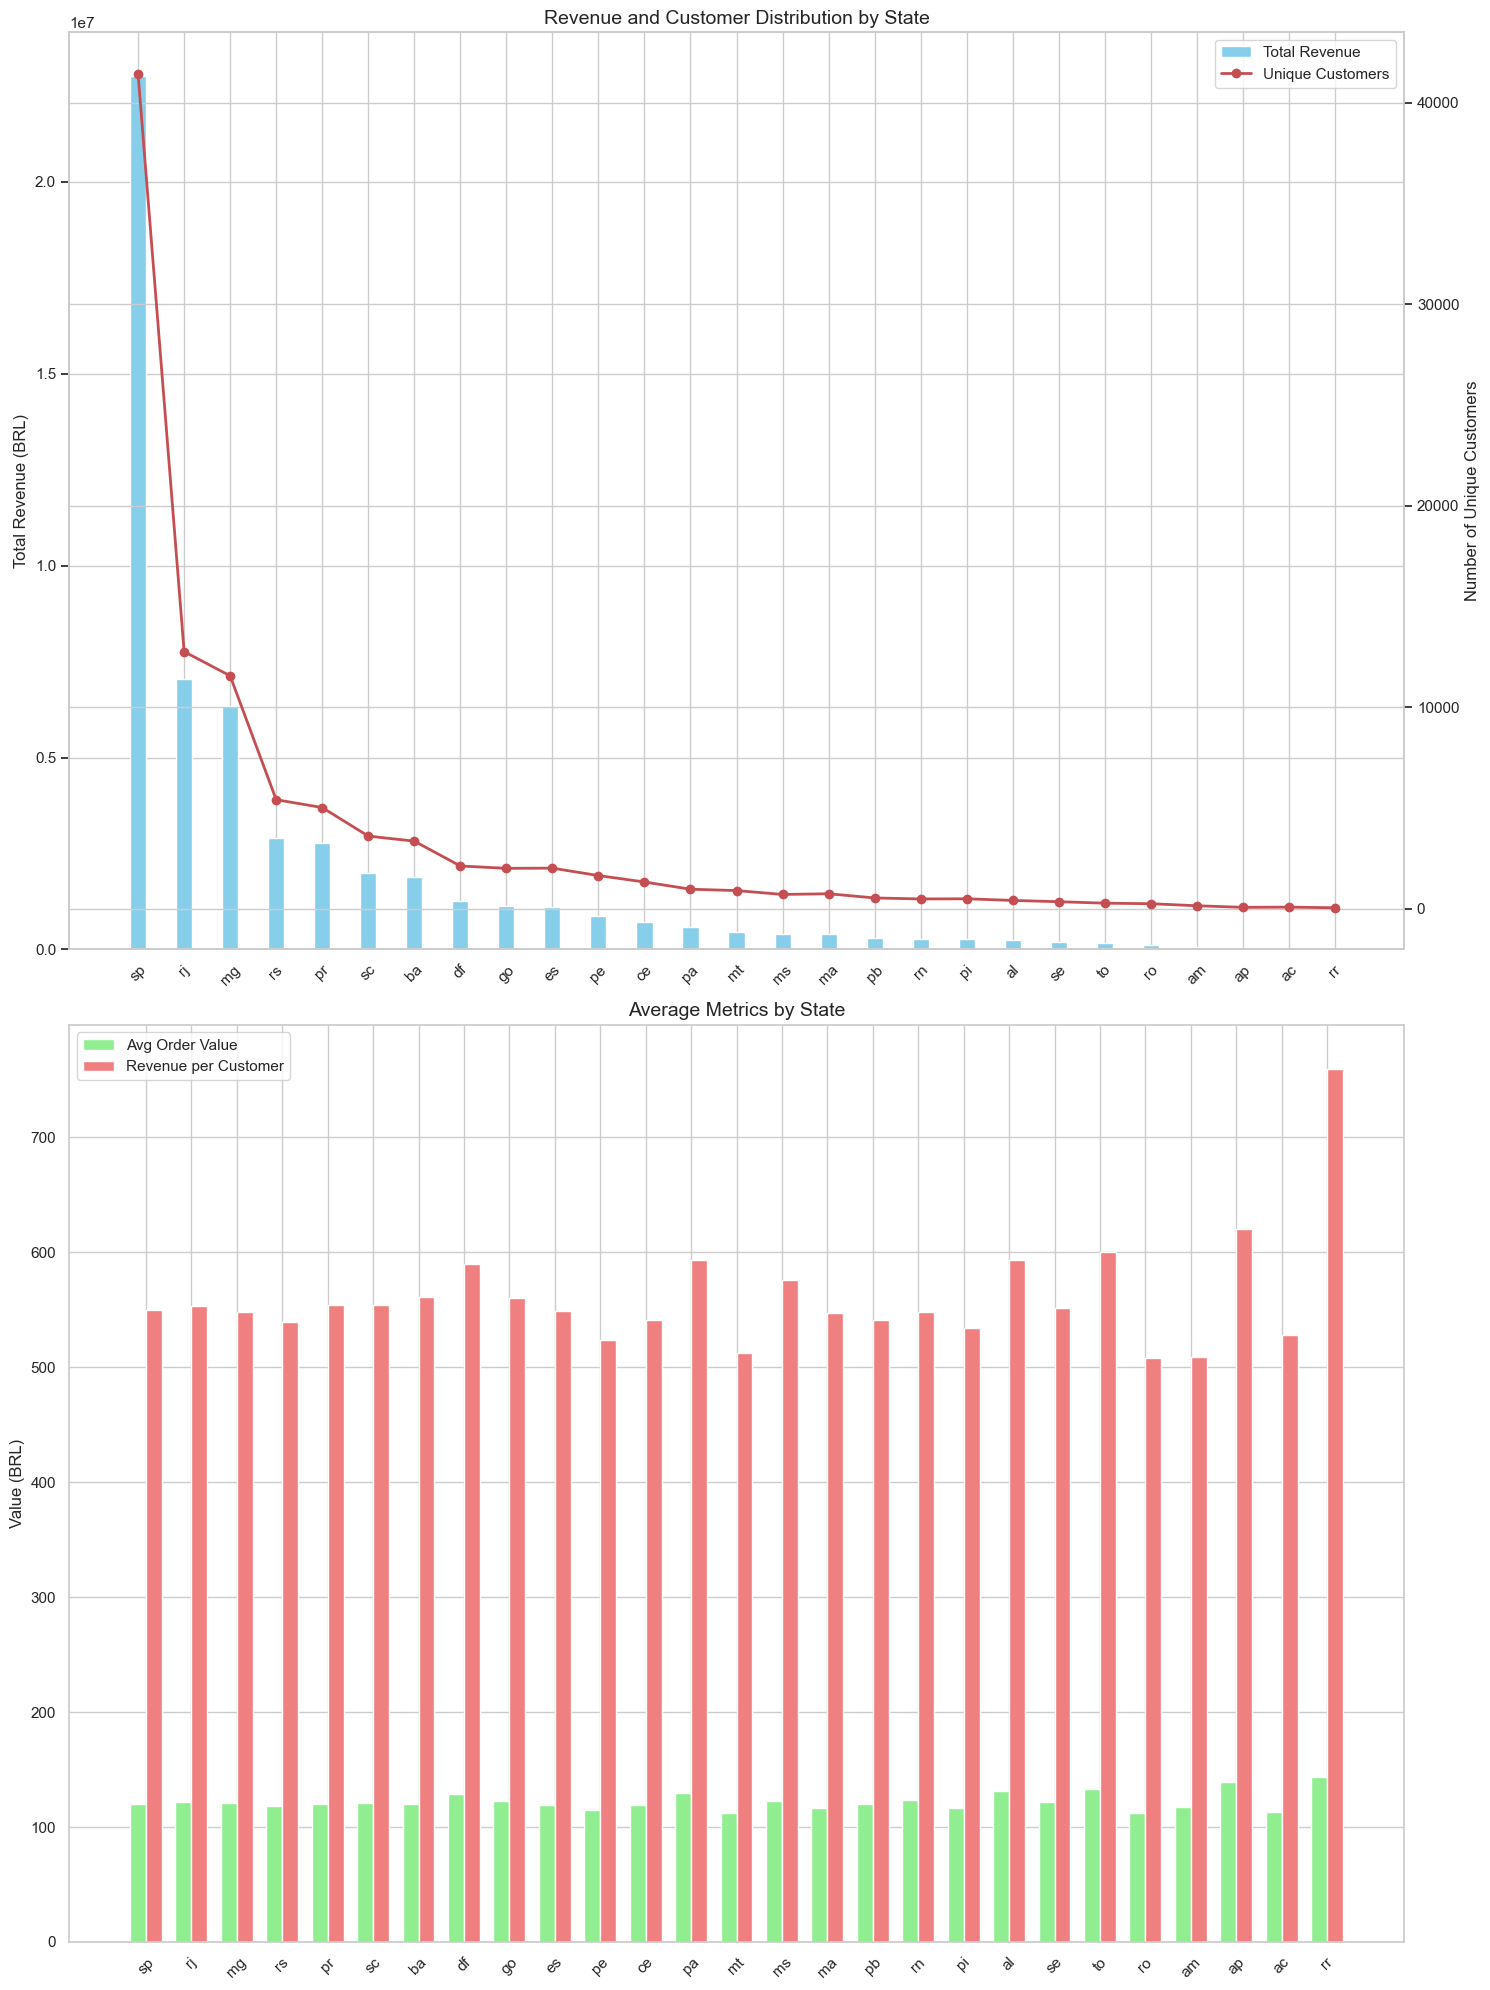

In [37]:
query_geo_analysis = """
SELECT 
    c.customer_state,
    COUNT(DISTINCT f.order_id) as total_orders,
    SUM(f.price) as total_revenue,
    COUNT(DISTINCT f.customer_key) as unique_customers,
    AVG(f.price) as avg_order_value,
    SUM(f.price) / COUNT(DISTINCT f.customer_key) as revenue_per_customer
FROM fact_orders f
JOIN dim_customer c ON f.customer_key = c.customer_key
GROUP BY c.customer_state
ORDER BY total_revenue DESC;
"""

geo_analysis = get_data(query_geo_analysis)

fig, axes = plt.subplots(2, 1, figsize=(15, 20))

# Top plot: Total Revenue vs. Unique Customers by State
ax1 = axes[0]
x = range(len(geo_analysis))
width = 0.35
ax2 = ax1.twinx()

bars1 = ax1.bar(x, geo_analysis['total_revenue'], width, label='Total Revenue', color='skyblue')
line = ax2.plot(x, geo_analysis['unique_customers'], 'r-o', label='Unique Customers', linewidth=2)

ax1.set_xticks(x)
ax1.set_xticklabels(geo_analysis['customer_state'], rotation=45)
ax1.set_ylabel('Total Revenue (BRL)')
ax2.set_ylabel('Number of Unique Customers')
ax1.set_title('Revenue and Customer Distribution by State')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Bottom plot: Average Order Value and Revenue per Customer by State
ax3 = axes[1]
bars2 = ax3.bar([i - width/2 for i in x], geo_analysis['avg_order_value'], width, label='Avg Order Value', color='lightgreen')
bars3 = ax3.bar([i + width/2 for i in x], geo_analysis['revenue_per_customer'], width, label='Revenue per Customer', color='lightcoral')

ax3.set_xticks(x)
ax3.set_xticklabels(geo_analysis['customer_state'], rotation=45)
ax3.set_ylabel('Value (BRL)')
ax3.set_title('Average Metrics by State')
ax3.legend()

plt.tight_layout()
plt.show()

## 4. Customer Segmentation

To better understand the customer base, let's segment customers into tiers based on their total monetary value (spending) and evaluate their average spending and order frequency.

We will:
- Compute frequency (number of orders) and monetary value (total spending) per customer.
- Use percentiles to divide customers into Low, Medium, and High spending segments.
- Visualize the distribution of these segments and compare their average spending and order frequency.

C:\Users\hp\AppData\Local\Temp\ipykernel_24976\1508245647.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query(query, conn)


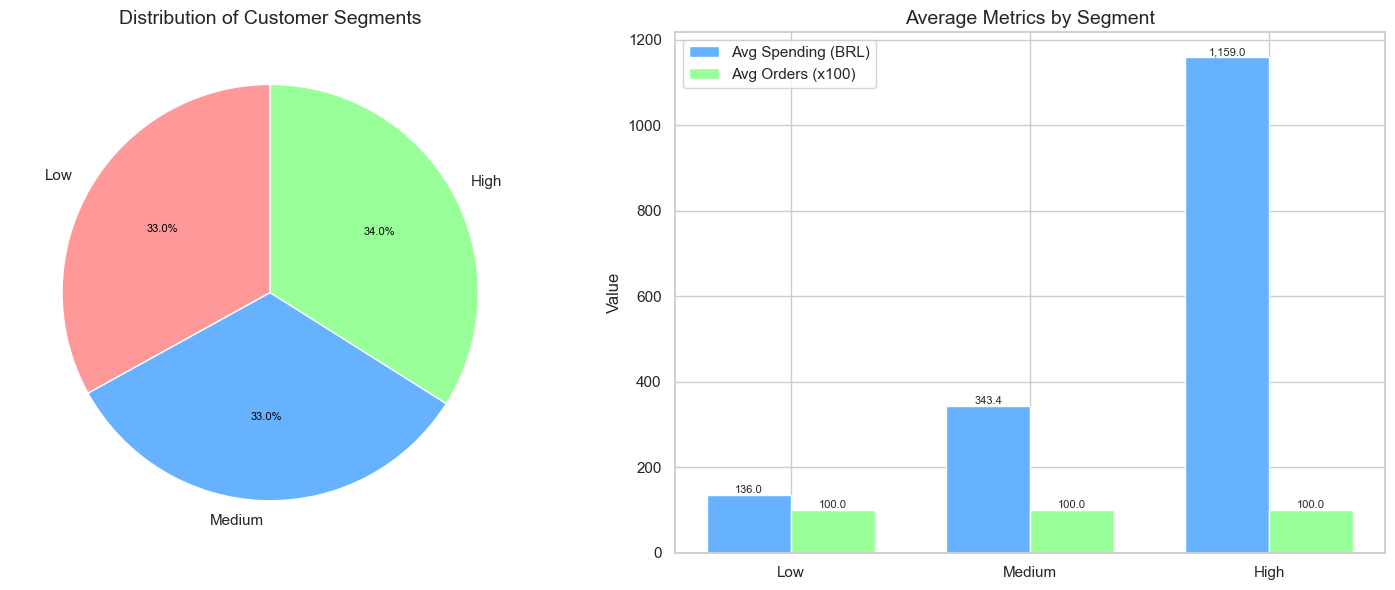


Customer Segment Statistics:
--------------------------------------------------

Segment: Low
Number of Customers: 23,293
Average Spending: R$135.97
Average Orders: 1.00

Segment: Medium
Number of Customers: 23,275
Average Spending: R$343.39
Average Orders: 1.00

Segment: High
Number of Customers: 23,941
Average Spending: R$1,158.95
Average Orders: 1.00


In [38]:
query_customer_segments = """
WITH customer_metrics AS (
    SELECT 
        f.customer_key,
        COUNT(DISTINCT f.order_id) as frequency,
        SUM(f.price) as monetary
    FROM fact_orders f
    JOIN dim_date d ON f.purchase_date_key = d.date_key
    GROUP BY f.customer_key
),
percentiles AS (
    SELECT 
        percentile_cont(0.33) WITHIN GROUP (ORDER BY monetary) as p33,
        percentile_cont(0.66) WITHIN GROUP (ORDER BY monetary) as p66
    FROM customer_metrics
),
segmented_customers AS (
    SELECT 
        cm.*,
        CASE 
            WHEN cm.monetary <= (SELECT p33 FROM percentiles) THEN 'Low'
            WHEN cm.monetary <= (SELECT p66 FROM percentiles) THEN 'Medium'
            ELSE 'High'
        END as spending_segment
    FROM customer_metrics cm
)
SELECT 
    spending_segment,
    COUNT(*) as customer_count,
    ROUND(AVG(monetary)::numeric, 2) as avg_spending,
    ROUND(AVG(frequency)::numeric, 2) as avg_frequency
FROM segmented_customers
GROUP BY spending_segment
ORDER BY avg_spending;
"""

customer_segments = get_data(query_customer_segments)

# Visualize the segmentation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Pie chart for segment distribution
colors = ['#FF9999', '#66B2FF', '#99FF99']
wedges, texts, autotexts = ax1.pie(
    customer_segments['customer_count'],
    labels=customer_segments['spending_segment'],
    colors=colors,
    autopct='%1.1f%%',
    startangle=90
)
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(8)
ax1.set_title('Distribution of Customer Segments')

# Bar chart comparison of average metrics
x = range(len(customer_segments))
width = 0.35
spending_bars = ax2.bar([i - width/2 for i in x], customer_segments['avg_spending'], width, label='Avg Spending (BRL)', color='#66B2FF')
freq_bars = ax2.bar([i + width/2 for i in x], customer_segments['avg_frequency'] * 100, width, label='Avg Orders (x100)', color='#99FF99')

ax2.set_xticks(x)
ax2.set_xticklabels(customer_segments['spending_segment'])
ax2.set_ylabel('Value')
ax2.set_title('Average Metrics by Segment')
ax2.legend()

# Add value labels
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:,.1f}',
                ha='center', va='bottom', fontsize=8)

add_value_labels(spending_bars)
add_value_labels(freq_bars)

plt.tight_layout()
plt.show()

# Print detailed statistics
print("\nCustomer Segment Statistics:")
print("-" * 50)
for _, row in customer_segments.iterrows():
    print(f"\nSegment: {row['spending_segment']}")
    print(f"Number of Customers: {row['customer_count']:,}")
    print(f"Average Spending: R${row['avg_spending']:,.2f}")
    print(f"Average Orders: {row['avg_frequency']:.2f}")

## Conclusion

In this notebook, we've connected to a PostgreSQL database and explored the Olist e-commerce dataset from multiple perspectives:
- **Time-based Analysis:** We identified trends in total sales, average order value, and customer growth over time.
- **Product Categories:** We highlighted the top revenue-generating categories and observed their relative performance.
- **Geographic Insights:** We explored revenue and customer metrics by state, identifying variations in customer density, spending, and order values.
- **Customer Segmentation:** We segmented customers by their spending patterns, providing insights into customer distribution and behavior.

These visualizations and analyses form a foundation for further deep dives into marketing strategies, inventory planning, and personalized customer experiences.